In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xlrd
import warnings
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image

In [3]:
# Load the excel data using pandas into a data frame with a reference to sheet name
xl_file = pd.read_excel(open('data/eBayAuctions.xlsx','rb'), sheetname='eBay auctions')
xl_file.head()

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [4]:
# Training and validation split of our data
tsize = np.floor(0.60 * len(xl_file))
data_train = xl_file.iloc[:int(tsize),:]
data_validation = xl_file.iloc[int(tsize):,:]

In [5]:
# Length of the training data (60%)
len(data_train)

1183

In [6]:
# Length of the validation data (40%)
len(data_validation)

789

In [7]:
# Setup dummy variables for the category column
category_train_dummies = pd.get_dummies(data_train['Category'])
category_train_dummies.head(10)

,Antique/Art/Craft,Automotive,Books,Business/Industrial,Clothing/Accessories,Coins/Stamps,Collectibles,Computer,Electronics,EverythingElse,Health/Beauty,Home/Garden,Jewelry,Music/Movie/Game,Photography,Pottery/Glass,SportingGoods,Toys/Hobbies
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:
# Setup dummy variables for the currency column
currency_train_dummies = pd.get_dummies(data_train['currency'])
currency_train_dummies.head(10)

,EUR,GBP,US
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
6,0.0,0.0,1.0
7,0.0,0.0,1.0
8,0.0,0.0,1.0
9,0.0,0.0,1.0


In [9]:
# Setup dummy variables for the end day column
endDay_train_dummies = pd.get_dummies(data_train['endDay'])
endDay_train_dummies.head(10)

,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# Create a classification tree using scikit learn based upon category and sellerRating
# http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# http://scikit-learn.org/stable/modules/tree.html#tree
cat_d_tree = DecisionTreeClassifier(random_state=0, max_depth=3)
cat_d_tree.fit(category_train_dummies, data_train['sellerRating'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [58]:
# Use export_graphviz to general a data file to be converted into an image
# sudo apt-get install graphviz
# Restart iPython
export_graphviz(cat_d_tree, 
                feature_names=data_train['Category'], 
                proportion=True, 
                rounded=True, 
                filled=True,
                out_file="category.dot", )

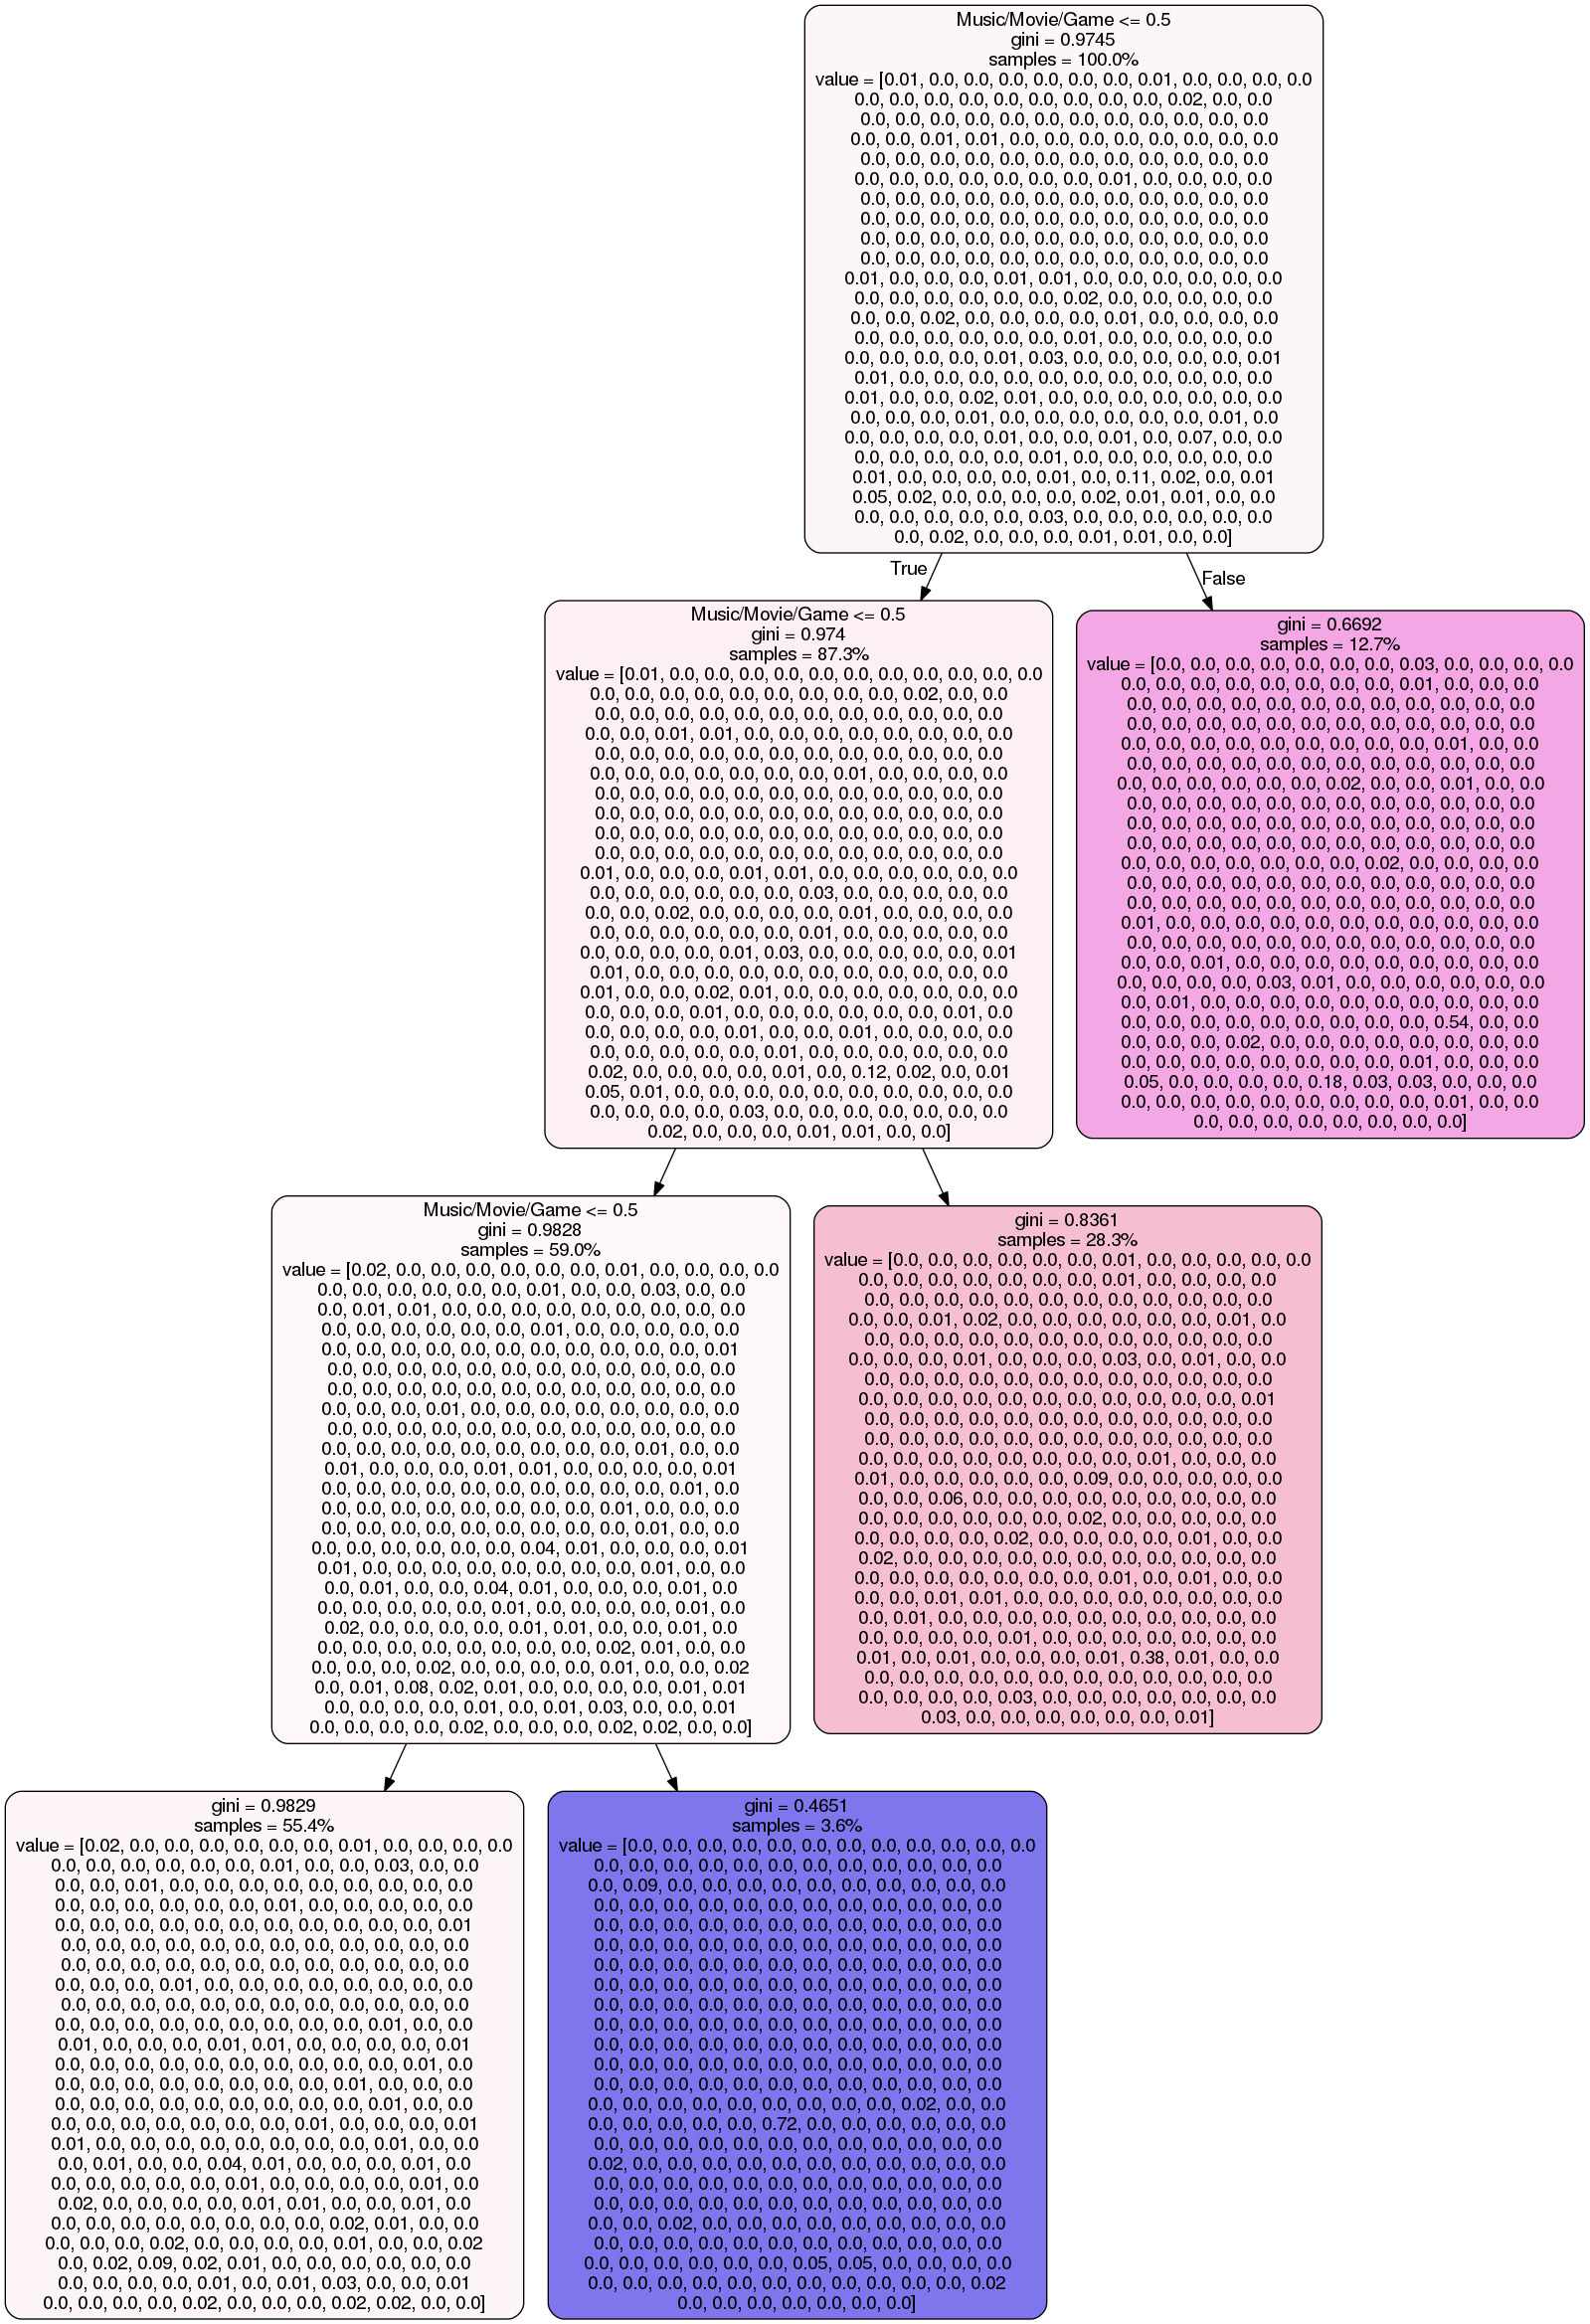

In [59]:
# $ dot -Tpng category.dot -o category.png
# https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html
# Use IPython's core image library to display the tree within a specific width
Image("category.png", width=980, unconfined=True)

In [67]:
# Create a classification tree using scikit learn based upon category and sellerRating
# http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# http://scikit-learn.org/stable/modules/tree.html#tree
cur_d_tree = DecisionTreeClassifier(random_state=0, max_depth=3)
cur_d_tree.fit(currency_train_dummies, data_train['sellerRating'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [70]:
# Use export_graphviz to general a data file to be converted into an image
# sudo apt-get install graphviz
# Restart iPython
export_graphviz(cat_d_tree, 
                feature_names=data_train['Duration'], 
                proportion=True, 
                rounded=True, 
                filled=True,
                out_file="currency.dot", )

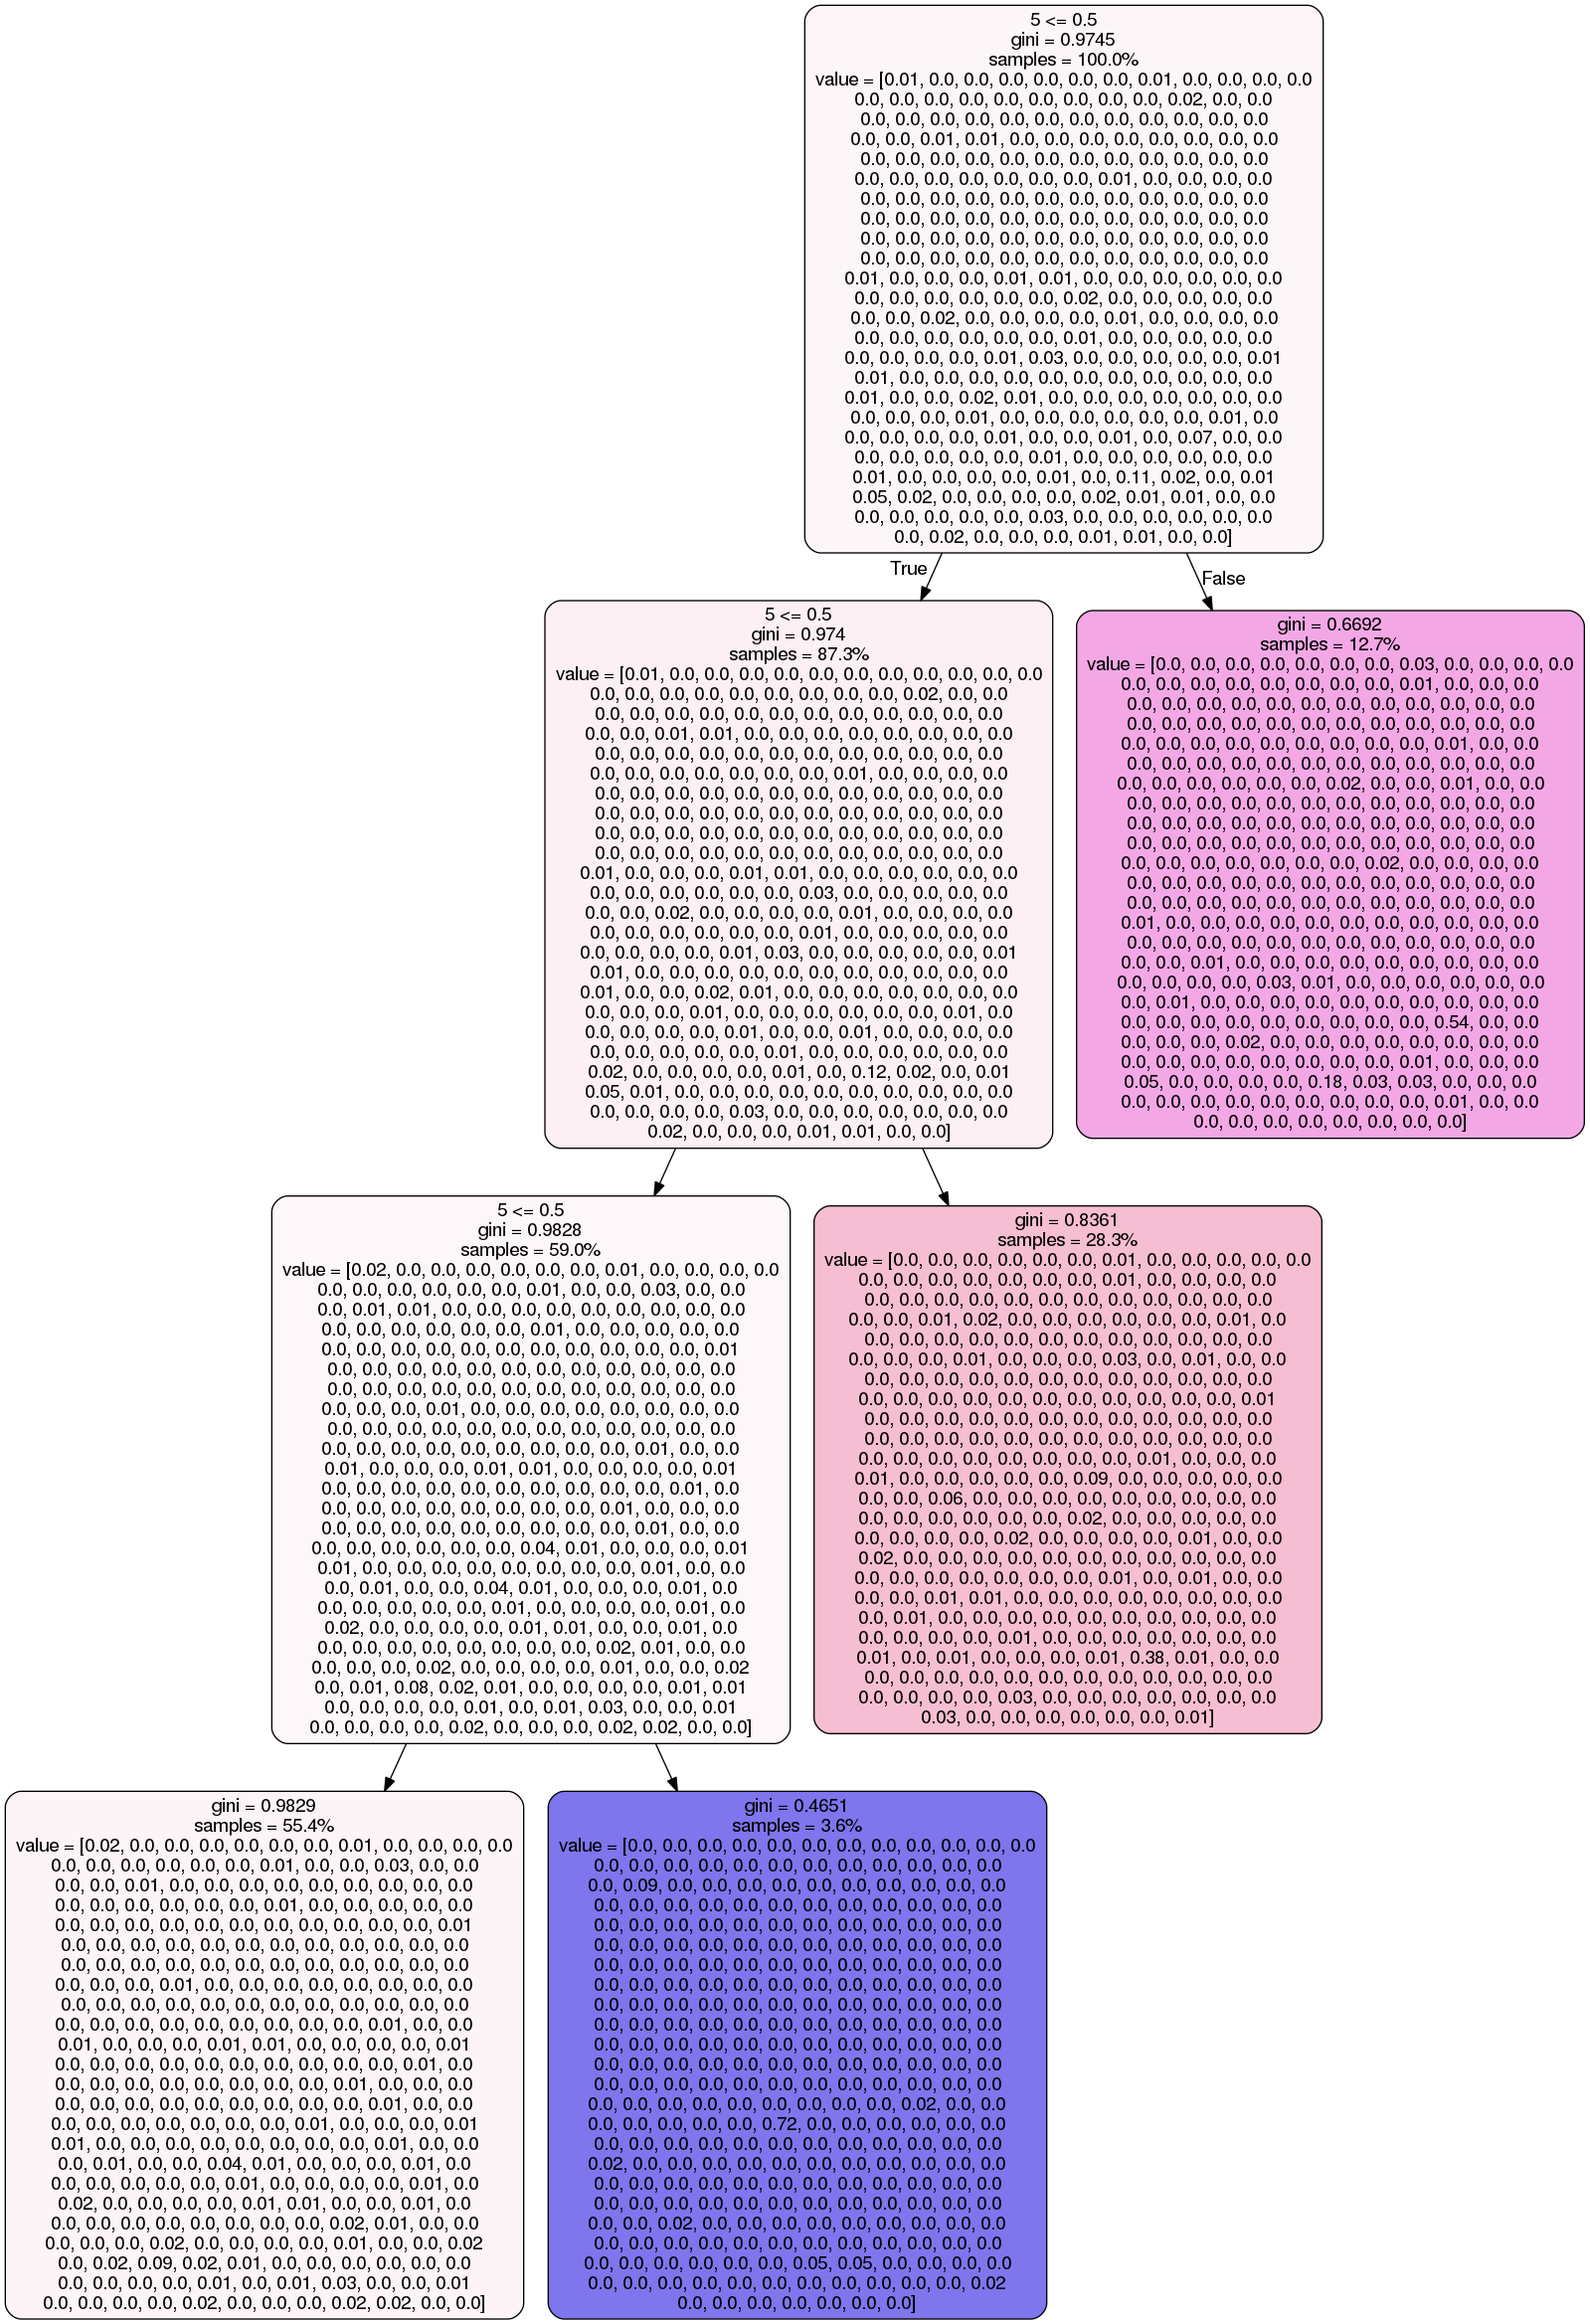

In [71]:
# $ dot -Tpng currency.dot -o currency.png
# https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html
# Use IPython's core image library to display the tree within a specific width
Image("currency.png", width=980, unconfined=True)

In [63]:
# Create a classification tree using scikit learn based upon endDay and sellerRating
# http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# http://scikit-learn.org/stable/modules/tree.html#tree
endDay_d_tree = DecisionTreeClassifier(random_state=0, max_depth=3)
endDay_d_tree.fit(endDay_train_dummies, data_train['sellerRating'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [64]:
# Use export_graphviz to general a data file to be converted into an image
# sudo apt-get install graphviz
# Restart iPython
export_graphviz(cat_d_tree, 
                feature_names=data_train['endDay'], 
                proportion=True, 
                rounded=True, 
                filled=True,
                out_file="endDay.dot", )

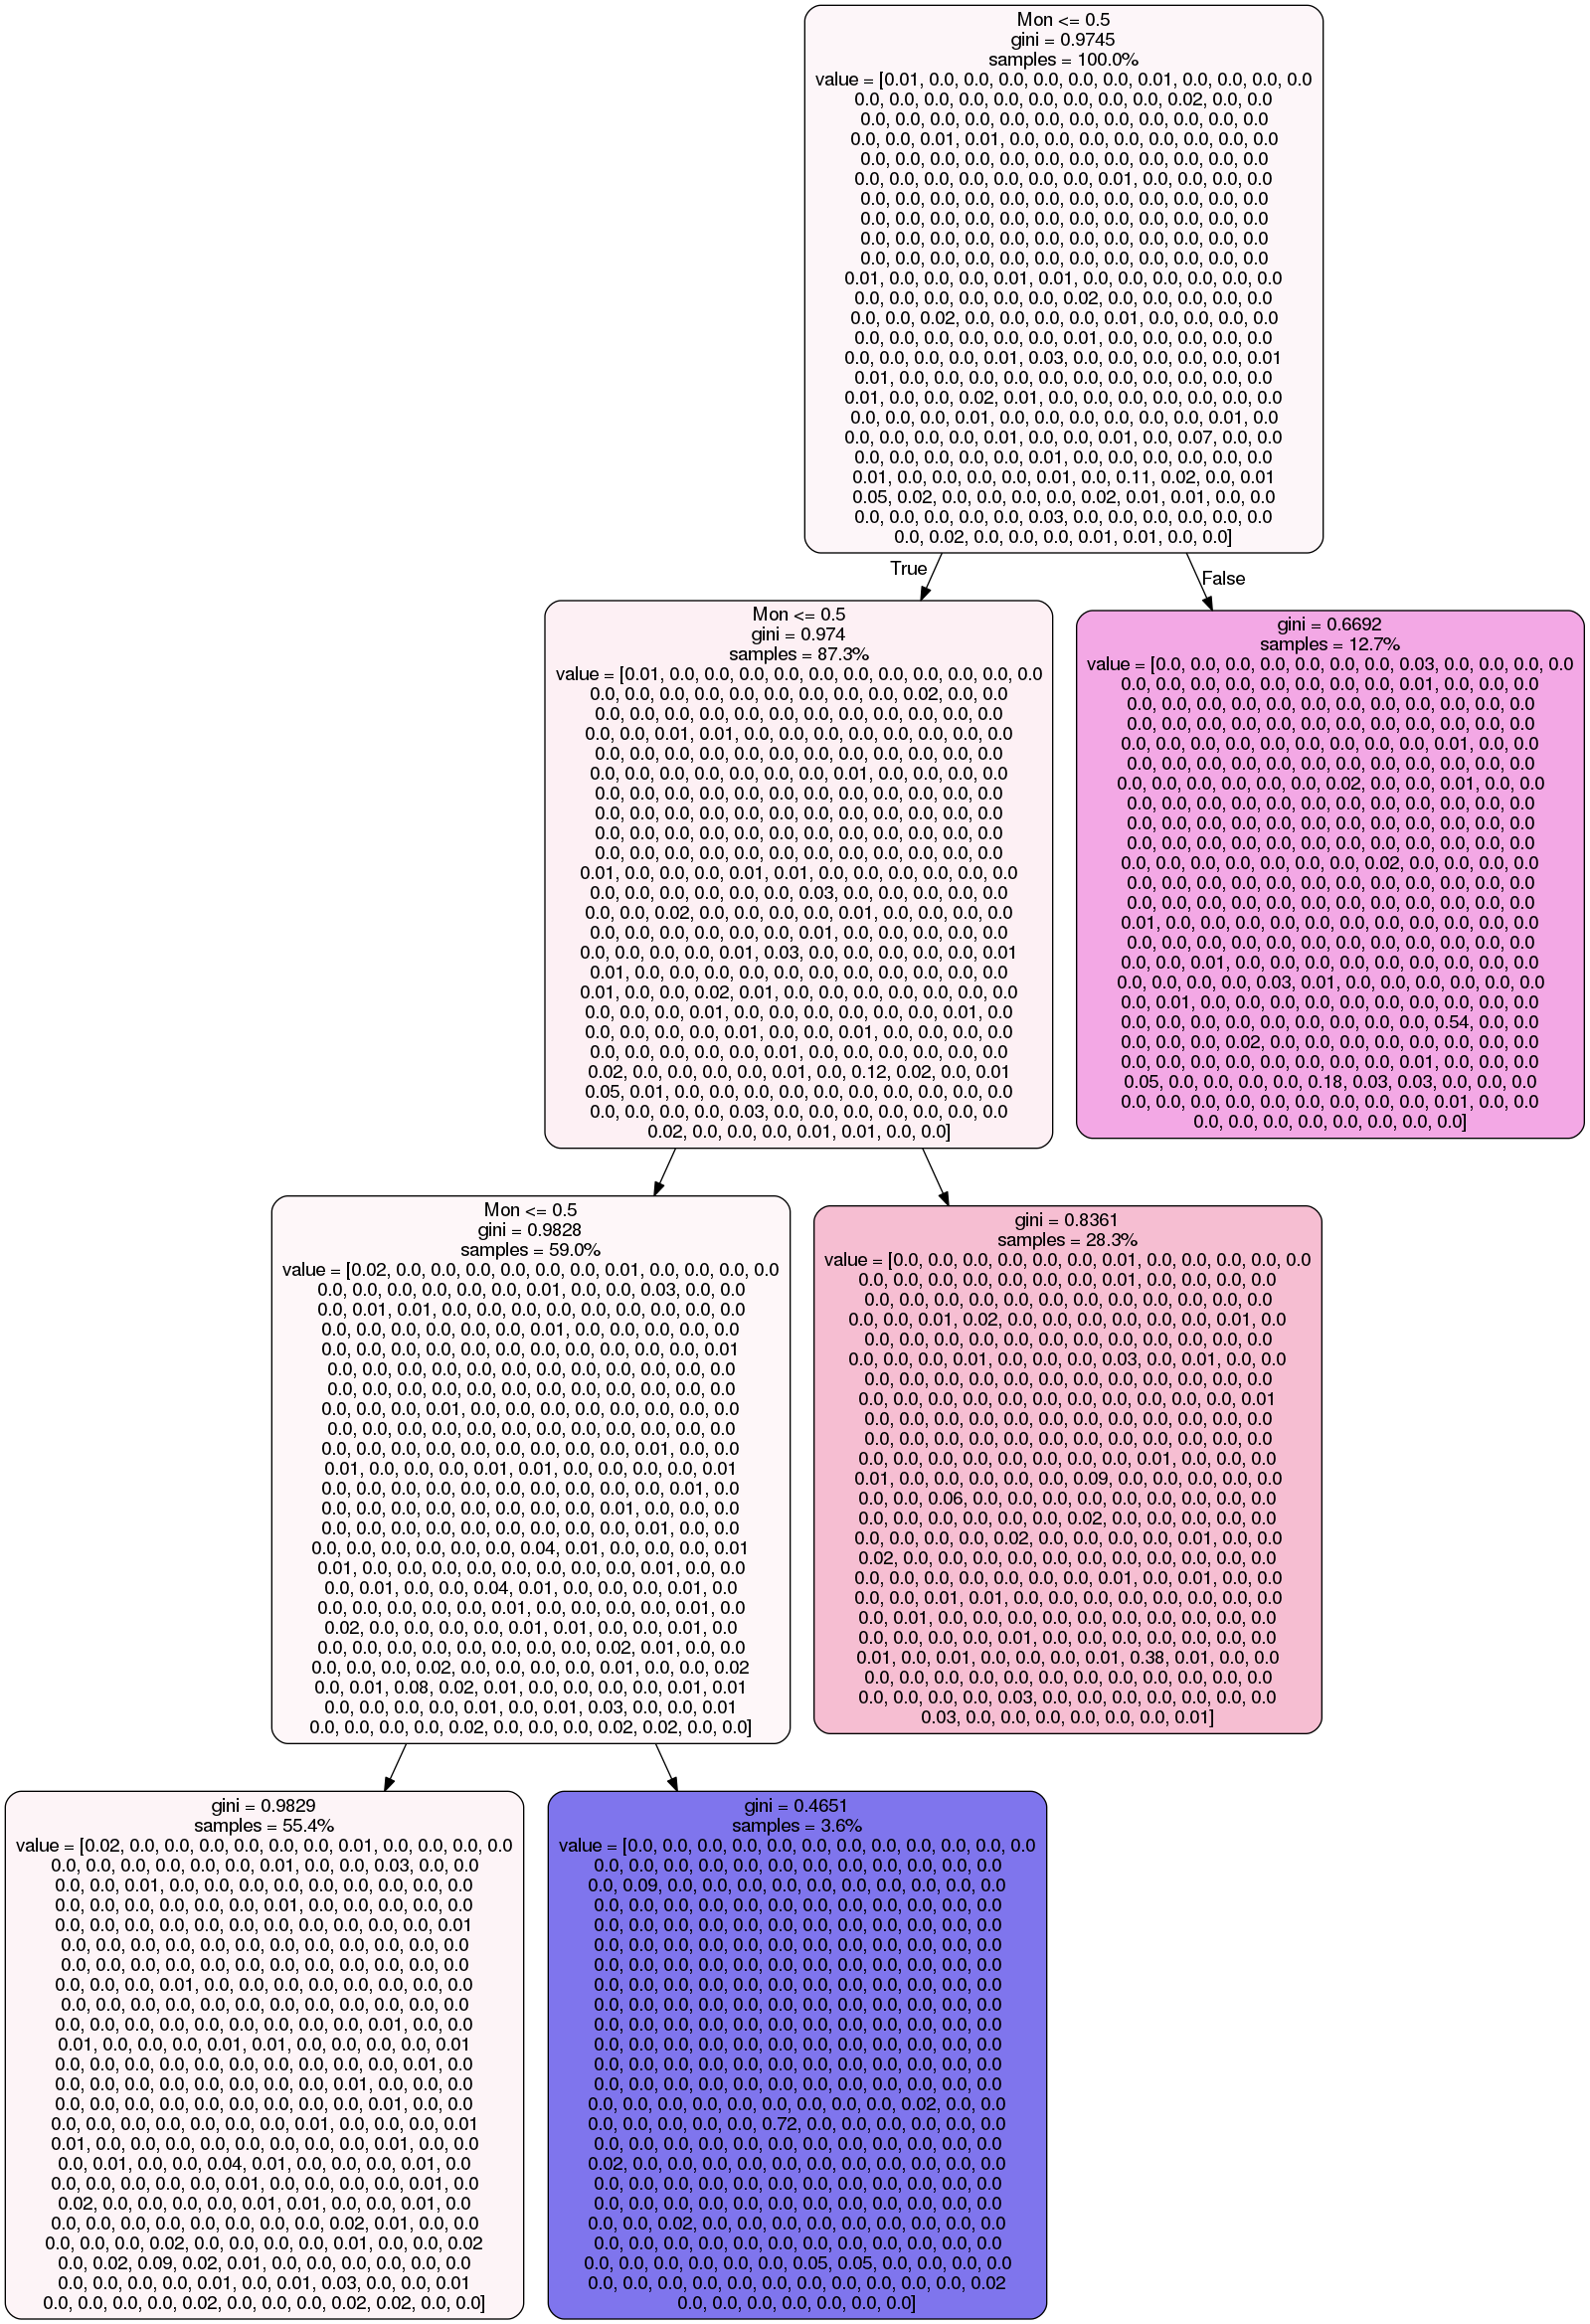

In [66]:
# $ dot -Tpng endDay.dot -o endDay.png
# https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html
# Use IPython's core image library to display the tree within a specific width
Image("endDay.png", width=980, unconfined=True)